# Sentiment Analysis on IMDb Movie Reviews

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('IMDB Dataset.csv')

data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Description of Data**

In [3]:
data.describe()

,review,sentiment
count,50000,50000
unique,49581,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


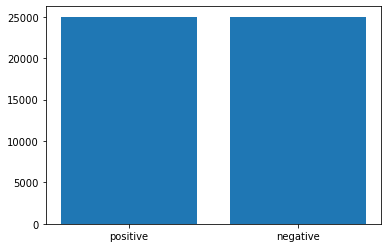

In [4]:
sentiments = data['sentiment'].value_counts()

bar = plt.bar(sentiments.index, sentiments)

## Data Preprocessing

**Removing duplicate reviews.**

In [5]:
data.drop_duplicates(inplace=True, ignore_index=True)

data.shape

(49581, 2)

**Checking for any missing values.**

In [6]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

**Segregating reviews and its sentiments.**

In [7]:
X = data['review'].values
y = data['sentiment'].values

y = np.where(y == 'positive', 1, 0)

### Data Cleaning

**Removing HTML tags and special characters from reviews.**

In [8]:
from bs4 import BeautifulSoup
import re

In [9]:
def remove_special_characters(text):
    text = text.lower()

    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)

    return text

In [10]:
for index in range(len(X)):
    X[index] = remove_special_characters(X[index])

**Removing stopwords and stemming the documents after tokenization.**

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
english_stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

In [13]:
def get_clean_docs(text):
    # tokenizing each review and removing stopwords from them
    tokens = word_tokenize(text)
    clean_tokens = [token for token in tokens if token not in english_stopwords]

    # stemming the clean tokens
    stemmed_tokens = [ps.stem(token) for token in clean_tokens]

    return stemmed_tokens

In [14]:
for index in range(len(X)):
    X[index] = get_clean_docs(X[index])

### Splitting training and testing samples.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

## Vectorization: Word Embedding

The size of the vector is kept as 500. Different sizes has been tested before choosing this value. The factors for deciding the value: accuracy of model, space and time required to run the code.

In [16]:
from gensim.models import Word2Vec

vector_model_file = 'assets/word2vec_500.model'

vec_model = Word2Vec(X, min_count=1, size=500, workers=3, window=3, sg=0)
vec_model.save(vector_model_file)

**Vectorizing training samples.**

In [17]:
train_vector_file = 'assets/train_vector.csv'

In [18]:
vec_model = Word2Vec.load('assets/word2vec_500.model')

with open(train_vector_file, 'w+') as f:
    for index, tokens in enumerate(X_train):
        model_vector = (np.mean([vec_model.wv.__getitem__(token) for token in tokens], axis=0)).tolist()

        if index == 0:
            header = ','.join(str(num) for num in range(500))
            f.write(header)
            f.write('\n')

        if type(model_vector) is list:
            line = ','.join([str(vector_element) for vector_element in model_vector])
        else:
            line = ','.join([str(0) for _ in range(500)])

        f.write(line)
        f.write('\n')

**Vectorizing test samples.**

In [19]:
test_vector_file = 'assets/test_vector.csv'

In [20]:
with open(test_vector_file, 'w+') as f:
    for index, tokens in enumerate(X_test):
        model_vector = (np.mean([vec_model.wv.__getitem__(token) for token in tokens], axis=0)).tolist()

        if index == 0:
            header = ','.join(str(num) for num in range(500))
            f.write(header)
            f.write('\n')

        if type(model_vector) is list:
            line = ','.join([str(vector_element) for vector_element in model_vector])
        else:
            line = ','.join([str(0) for _ in range(500)])

        f.write(line)
        f.write('\n')

## Classification Model

In [9]:
X_train_vec = pd.read_csv('assets/train_vector.csv').to_numpy()
X_test_vec = pd.read_csv('assets/test_vector.csv').to_numpy()

Each review is represented in the form of vector. Vector for the first review is shown below.

In [10]:
print(X_train_vec[0])

[-3.40510830e-02 -2.91176382e-02 -6.79341108e-02 -9.64727812e-03
  2.38459513e-01  6.94403425e-02 -1.10823788e-01  4.74482894e-01
  2.88223714e-01 -4.07446563e-01  3.53135029e-03  2.50592589e-01
 -1.77818313e-01 -1.60988271e-01 -2.04619750e-01  4.49727811e-02
 -4.48829651e-01 -2.49349549e-01  2.84367114e-01 -5.64782359e-02
  1.14819534e-01  2.78499752e-01  1.00064173e-01 -2.50650197e-01
 -1.74350813e-01 -1.27368793e-01 -2.97449213e-02 -2.63800234e-01
  1.97774112e-01  1.71895176e-02  1.36392206e-01  2.43351802e-01
 -8.38586390e-02 -4.87170592e-02  3.29676829e-02  3.62103373e-01
 -3.22424740e-01 -8.68681371e-02  2.16373026e-01  1.37712210e-01
 -1.85590237e-01 -9.10326093e-02  4.74748164e-01 -2.86275536e-01
  1.88133001e-01  2.91677535e-01 -2.51563936e-01  6.63617179e-02
  3.19098800e-01  2.71147341e-01  4.12615109e-03  1.64832198e-03
 -1.59191974e-02  4.47655559e-01 -1.53400138e-01 -8.83178934e-02
  1.31227717e-01  4.50723339e-03  6.55383840e-02  2.66768318e-02
 -1.06446892e-01 -4.11911

**Splitting the training samples into training and validation purpose.**

In [11]:
X_train_vec, X_valid_vec, y_train, y_valid = train_test_split(X_train_vec, y_train, test_size=0.1, random_state=100)

**Importing different performance metrics for Classification Models.**

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

**Applying the Logistic Regression model on validation samples {max_iter=500}.**

In [33]:
first_lr = LogisticRegression(max_iter=500)
first_lr.fit(X_train_vec, y_train)

y_pred = first_lr.predict(X_valid_vec)

In [34]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8657447421492366


**Applying the Logistic Regression model on validation samples {max_iter=1000}.**

In [35]:
second_lr = LogisticRegression(max_iter=1000)
second_lr.fit(X_train_vec, y_train)

y_pred = second_lr.predict(X_valid_vec)

In [36]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8657447421492366


**Applying the first model on testing samples.**

In [38]:
y_pred = first_lr.predict(X_test_vec)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      7432
           1       0.85      0.86      0.86      7443

    accuracy                           0.86     14875
   macro avg       0.86      0.86      0.86     14875
weighted avg       0.86      0.86      0.86     14875



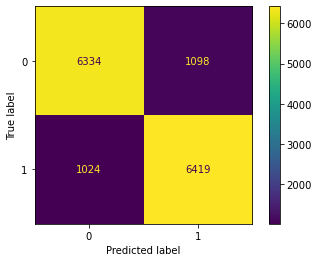

In [40]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)

disp.plot()
plt.show()

In [41]:
print(f'Accuracy Score (%): {accuracy_score(y_test, y_pred)}')

Accuracy Score (%): 0.8573445378151261


### Support Vector Machine

In [43]:
from sklearn.svm import SVC

**Applying the Support Vector model on validation samples {kernel=linear}.**

In [44]:
first_sv = SVC(kernel='linear')
first_sv.fit(X_train_vec, y_train)

y_pred = first_sv.predict(X_valid_vec)

In [45]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8657447421492366


**Applying the Support Vector model on validation samples {kernel='poly', degree=2}.**

In [46]:
second_sv = SVC(kernel='poly', degree=2)
second_sv.fit(X_train_vec, y_train)

y_pred = second_sv.predict(X_valid_vec)

In [47]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8631518294439643


**Applying the Support Vector model on validation samples {kernel='poly', degree=3}.**

In [52]:
third_sv = SVC(kernel='poly', degree=3)
third_sv.fit(X_train_vec, y_train)

y_pred = third_sv.predict(X_valid_vec)

In [53]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8625756266205704


**Applying the Support Vector model on validation samples {kernel='rbf', gamma=0.1}.**

In [54]:
fourth_sv = SVC(kernel='rbf', gamma=0.1)
fourth_sv.fit(X_train_vec, y_train)

y_pred = fourth_sv.predict(X_valid_vec)

In [55]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8666090463843272


**Applying the Support Vector model on validation samples {kernel='rbf', gamma=0.4}.**

In [58]:
fifth_sv = SVC(kernel='rbf', gamma=0.4)
fifth_sv.fit(X_train_vec, y_train)

y_pred = fifth_sv.predict(X_valid_vec)

In [59]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8738115816767502


**Applying the Support Vector model on validation samples {kernel='rbf', gamma=1}.**

In [60]:
sixth_sv = SVC(kernel='rbf', gamma=1)
sixth_sv.fit(X_train_vec, y_train)

y_pred = sixth_sv.predict(X_valid_vec)

In [61]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.864016133679055


**Applying the fifth model on testing samples.**

In [62]:
y_pred = fifth_sv.predict(X_test_vec)

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7432
           1       0.86      0.87      0.86      7443

    accuracy                           0.86     14875
   macro avg       0.86      0.86      0.86     14875
weighted avg       0.86      0.86      0.86     14875



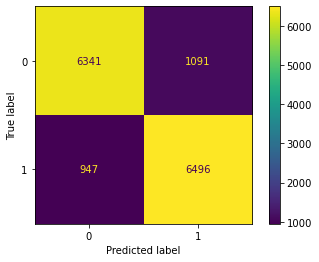

In [64]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)

disp.plot()
plt.show()

In [65]:
print(f'Accuracy Score (%): {accuracy_score(y_test, y_pred)}')

Accuracy Score (%): 0.8629915966386554


### K-Nearest Neighbors

In [66]:
from sklearn.neighbors import KNeighborsClassifier

Using distance metric as 'cosine similarity' as we're dealing with vectors.

**Applying KNN Classifier on validation samples {n_neighbors=10}.**

In [67]:
first_knc = KNeighborsClassifier(n_neighbors=10, metric='cosine')
first_knc.fit(X_train_vec, y_train)

y_pred = first_knc.predict(X_valid_vec)

In [68]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.7994814174589455


**Applying KNN Classifier on validation samples {n_neighbors=13}.**

In [69]:
second_knc = KNeighborsClassifier(n_neighbors=13, metric='cosine')
second_knc.fit(X_train_vec, y_train)

y_pred = second_knc.predict(X_valid_vec)

In [70]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8092768654566408


**Applying KNN Classifier on validation samples {n_neighbors=15}.**

In [71]:
third_knc = KNeighborsClassifier(n_neighbors=15, metric='cosine')
third_knc.fit(X_train_vec, y_train)

y_pred = third_knc.predict(X_valid_vec)

In [72]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8124459809853068


**Applying KNN Classifier on validation samples {n_neighbors=18}.**

In [75]:
fourth_knc = KNeighborsClassifier(n_neighbors=18, metric='cosine')
fourth_knc.fit(X_train_vec, y_train)

y_pred = fourth_knc.predict(X_valid_vec)

In [76]:
print(f'Accuracy Score (%): {accuracy_score(y_valid, y_pred)}')

Accuracy Score (%): 0.8043791414577931


**Applying third KNN model on testing samples.**

In [77]:
y_pred = third_knc.predict(X_test_vec)

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      7432
           1       0.83      0.79      0.81      7443

    accuracy                           0.81     14875
   macro avg       0.81      0.81      0.81     14875
weighted avg       0.81      0.81      0.81     14875



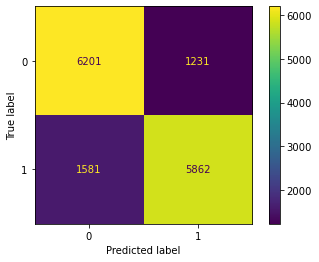

In [79]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)

disp.plot()
plt.show()

In [80]:
print(f'Accuracy Score (%): {accuracy_score(y_test, y_pred)}')

Accuracy Score (%): 0.8109579831932773


### Decision Tree Classifier

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [14]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_vec, y_train)

y_pred = dtc.predict(X_test_vec)

**Max Depth of the tree**

In [15]:
print(dtc.tree_.max_depth)

42


**Classification Report**

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      7432
           1       0.72      0.71      0.72      7443

    accuracy                           0.72     14875
   macro avg       0.72      0.72      0.72     14875
weighted avg       0.72      0.72      0.72     14875



**Confusion Matrix**

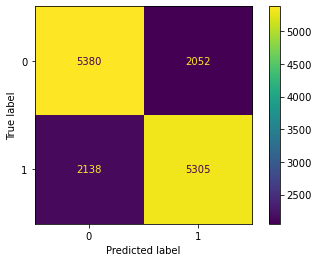

In [84]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix)

disp.plot()
plt.show()

**Accuracy Score**

In [85]:
print(f'Accuracy Score (%): {accuracy_score(y_test, y_pred)}')

Accuracy Score (%): 0.7183193277310924
